In [1]:
import sys
import glob
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nc_path = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/'
processing_mode = 'delayed'

files = sorted(glob.glob(nc_path + '*{}*.nc'.format(processing_mode)))
data_list = []
glider_record_list = []

for f in files:
    try:
        tmpData = xr.open_dataset(f, engine='netcdf4', decode_times=False)
        data_list.append(tmpData)
        tmpGliderRecordData = xr.open_dataset(f, engine='netcdf4', group='glider_record', decode_times=False)
        glider_record_list.append(tmpGliderRecordData)
        print('Processed {}'.format(f))
    except Exception as e:
        print('Ignore {}. Error: {}'.format(f, e))

raw_data = xr.concat(glider_record_list, dim='time').sortby('time')
data = xr.concat(data_list, dim='time').sortby('time')

# Convert xarray datasets to pandas dataframes
raw_data = raw_data.to_dataframe().reset_index()
data = data.to_dataframe().reset_index()

Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-0-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-1-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-0_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-1_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-2-2_delayed.nc
Processed /Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/delayed/nc/echo-2023-012-3-0_delayed.nc


## Correct lon/lat dead reckoning

In [2]:
# Path containing python functions
path = ['/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/']
sys.path.append(path[0])

from gliderfuncs import correct_dead_reckoning, findProfiles

data['lon_qc'],data['lat_qc'] = correct_dead_reckoning(raw_data['m_lon'],raw_data['m_lat'],raw_data['time'],raw_data['x_dr_state'],raw_data['m_gps_lon'],raw_data['m_gps_lat'])


## Find Profiles

In [3]:
data['profile_index'],data['profile_direction']=findProfiles(data['time'],data['depth'],stall=20,shake=200)

## Data QC

In [4]:
from quartod_qc import quartod_qc_checks

In [5]:
salinity_qc_flag = quartod_qc_checks(data['salinity'].values, data['time'].values, 'salinity')

done: test 1 - range check test for variable salinity
done: test 2 - spike test for variable salinity
done: test 3 - rate of change test for variable salinity
done: test 4 - flat line test for variable salinity


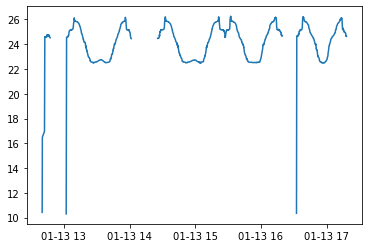

In [6]:
data['salinity_qc'] = data['salinity']
idx = salinity_qc_flag !=1 
data['salinity_qc'][idx] = np.nan

#plt.plot(data['salinity'])
plt.plot(np.array(data['time'], dtype='datetime64'),data['salinity_qc'])



## Attributes + Data Saving

In [7]:
'''
from data2attr import save_netcdf
fname='echo-trajectory_file.nc'
gliders_db = '/Users/research/Documents/GitHub/gliderProcessing/glider_reference_information/glider_serial-numbers_and_sensor-serial-numbers.csv'
metadata_source = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/metadata.yml'
encoder = '/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/attributes/glider_dac_3.0_conventions.yml'

source_info = {
    'gliders_db': gliders_db,
    'metadata_source': metadata_source,
    'encoder': encoder,
    'processing_mode': 'delayed',
    'data_type': 'trajectory',
    'data_source': files,
    'filename': fname,
    'filepath': nc_path
}

save_netcdf(data, raw_data,source_info)

# Check result
traj_file_name = sorted(glob.glob(nc_path + '*{}*.nc'.format('trajectory')))
traj_data = xr.open_dataset(traj_file_name[0], engine='netcdf4', decode_times=False)

traj_data
'''


"\nfrom data2attr import save_netcdf\nfname='echo-trajectory_file.nc'\ngliders_db = '/Users/research/Documents/GitHub/gliderProcessing/glider_reference_information/glider_serial-numbers_and_sensor-serial-numbers.csv'\nmetadata_source = '/Users/research/Documents/GitHub/gliderProcessing/glider_data/echo_20230113/metadata.yml'\nencoder = '/Users/research/Documents/GitHub/gliderProcessing/glider_processing_scripts/attributes/glider_dac_3.0_conventions.yml'\n\nsource_info = {\n    'gliders_db': gliders_db,\n    'metadata_source': metadata_source,\n    'encoder': encoder,\n    'processing_mode': 'delayed',\n    'data_type': 'trajectory',\n    'data_source': files,\n    'filename': fname,\n    'filepath': nc_path\n}\n\nsave_netcdf(data, raw_data,source_info)\n\n# Check result\ntraj_file_name = sorted(glob.glob(nc_path + '*{}*.nc'.format('trajectory')))\ntraj_data = xr.open_dataset(traj_file_name[0], engine='netcdf4', decode_times=False)\n\ntraj_data\n"

## PLOTS

In [8]:
'''

fig, ax = plt.subplots(figsize=(14,7))
plt.plot(data['time'],data['depth'])
plt.gca().invert_yaxis()
ax.set(xlabel='time', ylabel='depth(m)',
       title='Glider Dives')


fig, ax = plt.subplots(figsize=(14,7))
idx_down = np.flatnonzero(data['profile_index'] == 1)
idx_up = np.flatnonzero(data['profile_index'] == 2)
ax.plot(data['time'].values[idx_down], data['depth'].values[idx_down], 'o', label='down cast')
ax.plot(data['time'].values[idx_up], data['depth'].values[idx_up], 'o', label='up cast')
ax.set(xlabel='time (s)', ylabel='depth (m)',
       title='Algorithm for Profile Splitting Code')
plt.gca().invert_yaxis()
ax.grid()
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(14,7))
ax.plot(data['lon_qc'],data['lat_qc'],'o',label='corrected(underwater)')
ax.plot(raw_data['m_gps_lon'],raw_data['m_gps_lat'],'o',label='GPS(surface)')
ax.set(xlabel='longitude', ylabel='latitude',
       title='Algorithm for Deadreckoning Position Correction')
ax.grid()
ax.legend()
plt.show()


'''



"\n\nfig, ax = plt.subplots(figsize=(14,7))\nplt.plot(data['time'],data['depth'])\nplt.gca().invert_yaxis()\nax.set(xlabel='time', ylabel='depth(m)',\n       title='Glider Dives')\n\n\nfig, ax = plt.subplots(figsize=(14,7))\nidx_down = np.flatnonzero(data['profile_index'] == 1)\nidx_up = np.flatnonzero(data['profile_index'] == 2)\nax.plot(data['time'].values[idx_down], data['depth'].values[idx_down], 'o', label='down cast')\nax.plot(data['time'].values[idx_up], data['depth'].values[idx_up], 'o', label='up cast')\nax.set(xlabel='time (s)', ylabel='depth (m)',\n       title='Algorithm for Profile Splitting Code')\nplt.gca().invert_yaxis()\nax.grid()\nax.legend()\nplt.show()\n\n\nfig, ax = plt.subplots(figsize=(14,7))\nax.plot(data['lon_qc'],data['lat_qc'],'o',label='corrected(underwater)')\nax.plot(raw_data['m_gps_lon'],raw_data['m_gps_lat'],'o',label='GPS(surface)')\nax.set(xlabel='longitude', ylabel='latitude',\n       title='Algorithm for Deadreckoning Position Correction')\nax.grid()